# Write data to and read data from a TFRecord file

This notebook shows how to read and write TFRecord files.

This is based on the examples [convert_to_records.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/convert_to_records.py) and [fully_connected_reader.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py) on the TensorFlow repository, and on [this post](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/).

More info can be found on [TensorFlow's web page](https://www.tensorflow.org).

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
import tensorflow as tf

In [2]:
tf.version.VERSION

'2.7.0'

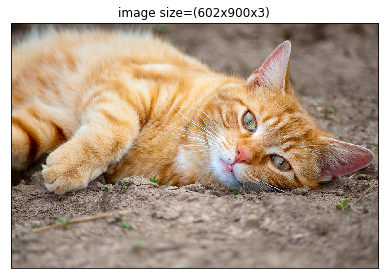

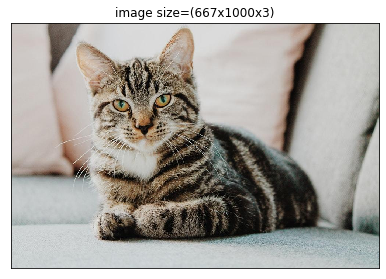

In [3]:
cat_array = io.imread('imgs/orange-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

cat_array = io.imread('imgs/gray-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

### 1. Define the types that will be written into the TFRecord file

In [4]:
def _bytes_feature(value):
    """Use this for string and byte types"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Use this for bool, enum, int32, uint32, int64 and uint64 types"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# This one is actually not used on this notebook. Its here just to show
# how the float case would be
def _float_feature(value):
    """Use this for float (float32) and double (float64) types"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [5]:
# Check how a value looks like as `Feature`
print(_float_feature(4.5))
print(_float_feature(4.5).SerializeToString())

float_list {
  value: 4.5
}

b'\x12\x06\n\x04\x00\x00\x90@'


### 2. Write the images and labels to a TFRecord file
The steps to write on a TFRecord file are:
 1. Create (open) a TFRecord file.
 2. Loop over the data. The data will be written on the TFRecord file row by row.
 3. Create a feature dictionary (`tf.train.Features`) which the desired keys. The corresponding values will be the data represented as TensorFlow feature types (`_bytes_feature`, `_int64_feature`, ...).
 4. Create an example (`tf.train.Example`) from the feature dictionary which will be a record on the TFRecord file.
 5. Serialize the examples.
 6. Write on the file.
 7. Close the file.

In [6]:
filename_label = [('imgs/orange-cat.jpg', 'orange-cat'),
                  ('imgs/gray-cat.jpg', 'gray-cat')]

tfrecords_filename = 'cats.tfrecords'

with tf.io.TFRecordWriter(tfrecords_filename) as writer:
    for img_path, label in filename_label:
        img = io.imread(img_path)  # read image as numpy array
        
        # Create an example, which will be a record on the TFRecord file
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'height': _int64_feature(img.shape[0]),
                'width': _int64_feature(img.shape[1]),
                'image': _bytes_feature(img.tostring()),
                'label': _bytes_feature(label.encode(encoding='utf-8'))
            }))

        writer.write(example.SerializeToString())

In [7]:
# Check how an `example` value looks like
features = {
    'a float feature': _float_feature(4.5),
    'a bytes feature': _bytes_feature(b'One cat is orange')
}
example = tf.train.Example(features=tf.train.Features(feature=features))
print(example)
print(example.SerializeToString())

features {
  feature {
    key: "a bytes feature"
    value {
      bytes_list {
        value: "One cat is orange"
      }
    }
  }
  feature {
    key: "a float feature"
    value {
      float_list {
        value: 4.5
      }
    }
  }
}

b'\nG\n\x1b\n\x0fa float feature\x12\x08\x12\x06\n\x04\x00\x00\x90@\n(\n\x0fa bytes feature\x12\x15\n\x13\n\x11One cat is orange'


***

### 3. Read from TFRecord file to Dataset object:

Steps:
 1. Load the TFRecord file to a dataset object with `the function tf.data.TFRecordDataset(tfrecords_filename)`.
 2. Create a function to parse the data from the TFRecord file into python or TensorFlow types and apply it through a map to the dataset.
 3. Do the normal operations to a dataset to define the input pipeline: maps, filters, batch, repeat, etc.
 
Parser function.
 1. Define a parser (`tf.io.parse_single_example`) from the serialized example and the features (keys) that will be loaded specifying their respective types (not all keys saved on the records need to be loaded).
 2. Cast each feature to the corresponding TensorFlow types.
 3. Return the the decoded data. 

In [8]:
def decode(serialized_example):
    """Parse an image and label from the given `serialized_example`."""

    example = tf.io.parse_single_example(
        serialized_example,
        features={
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string),
        })

    width = tf.cast(example['width'], tf.int64)
    height = tf.cast(example['height'], tf.int64)
    image = tf.io.decode_raw(example['image'], tf.uint8)
    label = tf.cast(example['label'], tf.string)
    image = tf.reshape(image, (height, width, 3))

    return image, label

In [10]:
# Define the input pipeline
dataset = tf.data.TFRecordDataset(tfrecords_filename)
dataset = dataset.map(decode)
dataset = dataset.batch(1)

orange-cat


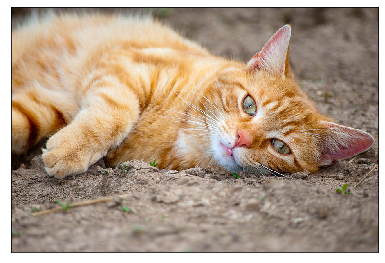

gray-cat


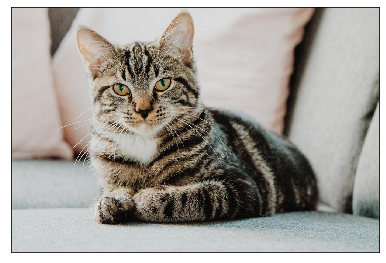

In [11]:
for image, label in dataset:
    io.imshow(image.numpy()[0])
    tf.print(label[0])
    plt.xticks([])
    plt.yticks([])
    plt.show()